# Credit Risk
# Bachelor Thesis - Bocconi University 

## Credit risk modelling: an empirical analysis on Probability of Default (PD) estimation 
solution provided by: **Daniel Travaglia**

## Draft of the outline of the notebook

0. Prerequisites: set up the environment
1. Introduction: frame the problem
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning for modelling (missing values) 
5. Machine Learning Pipelines:
    - Model (1): Logistic Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model 
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model
6. Get the best model (metric comparison)
7. Evaluate the system on the test set and plot the results
8. Conclusions
9. (Bonus) Further improvements

## TODO
1) [DONE] Restructure the notebook and retrieve the final index!

2) [TODO -> Today] Explanatory analysis + Give appropriate introduction and description

3) [TODO -> Today/Tomorrow] Calibration of default probability: since we do not have time-series data, we could actually calibrate default probabilities per-group: group by ratings and then by whether the client defaulted or not. At this point, estimate the probability of defaulting (modelling using a Bernoulli RV then) by calculating the proportion of defaulted clients out of the total clients for that specific rating 

4) [TODO -> Tomorrow] -> Provide a high-level overview of the credit risk world, with a particular attention in being able to introduce the topic in an understandable manner!

5) [TODO -> Today] -> injecting interest rates (missings) based on the information provided by ratings (random sampling between min-max of int. rates for a specific ranking)

# (0) Set up the environment

In this section we will retrieve all the required libraries and the set up in order to be able to properly read the data

### (0.1) Retrieving libraries

In [6]:
# Data manipulation ML libraries
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.stats import norm

# Ignore irrelevant warnings to make the code nicer!
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# database libraries
import pyodbc                       

# graphic settings
# Make things work smoother for plots
%matplotlib inline
# Se the backend of plotting to matplotlib
pd.options.plotting.backend = 'matplotlib'
# Change the style of seaborn graphs
sns.set_style("white")
sns.set_palette("Blues")

### (0.1) Loading data settings

In [7]:
## CSV
# Counterparty data path
cp_path = "data\counterparty.csv"
# Counterparty loans data path
cp_loans_path = "data\counterparty_loans.csv"

In [8]:
## SQL Server

# # Defining connection string
# driver = "{SQL Server}"
# server = "DESKTOP-KI4LIGE" # retrieve this in SQL by typing @@SERVERNAME
# database = "Thesis"
# connection = "yes"
# conn_string = f"Driver={driver};Server={server};Database={database};Trusted_Connection={connection}"

# # Defining connection string
# conn = pyodbc.connect(conn_string)

# # Defining query to extract data from tables
# sql_cp_query = """
#     SELECT * 
#     FROM dbo.Counterparty
# """
# sql_cp_loans_query = """
#     SELECT *
#     FROM dbo.Counterparty_loan
# """

In [9]:
# MongoDB

# (1) Introduction: frame the problem

[TODO]: Provide a high-level description of what is credit risk modelling, what characterize it and how this activity is usually done in financial istitutions. Particular attention on PD, EAD and LGD.

## Recap

[Little recap of what we have covered in this chapter and why it is relevant in this context]

# (2) Retrieve and describe the dataset

In this section we will use the options defined above to pull the data from the source and provide a high-level overview and description of the data used for the analysis


## (2.1) Loading the datasets

The data are spread across 2 different tables:

* Counterparty: contains all the information on the counterparties that were granted with a loan 
* Counterparty_loans: contains all the information related to the granted loans.

### (2.1.1) Retrieving data from CSV

In [10]:
# Retrieving counterparty data
df_cp = pd.read_csv(cp_path)
# Retrieving counterparty loans data
df_cp_loans = pd.read_csv(cp_loans_path)

# make sure the file is loaded
assert not (df_cp.empty and df_cp_loans.empty)

### (2.1.2) Retrieving data from SQL server

In [11]:
# # Injecting data into pandas DateFrame
# df_cp = pd.read_sql(sql_cp_query,conn)
# df_cp_loans = pd.read_sql(sql_cp_loans_query,conn)

# # Inspecting whether we have indeed extract something out of the SQL server
# assert not (df_cp.empty or df_cp_loans.empty)

### (2.1.3) Retrieving data from MongoDB server

In [2]:
# MongoDB

## (2.2) A first glence at the data

We will first dig into the counterparty table, and then we will proceed by analyzing also the loans. Eventally, we will merge the two tables to get a comprehensive overview of the customer and the related loan and in order to extract further useful information

### (2.2.1) Counterparties dataset

In [15]:
df_cp.shape

(32581, 7)

The counterparty dataset contains 32581 observations, each of which represents a specific counterparty. Each observation is then described by 7 different features. Let's now dig a little bit more to discover what type of information we have on the counterparties

In [18]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cp                       32581 non-null  int64  
 1   cp_age                      32581 non-null  int64  
 2   cp_income                   32581 non-null  int64  
 3   cp_home_ownership           32581 non-null  object 
 4   cp_emp_length               31686 non-null  float64
 5   cp_person_default_on_file   32581 non-null  object 
 6   cp_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.7+ MB


The dataset provides the following information regarding the counterparties: 
* Age: age of the person 
* Income: personal income in $ (dollars)
* Home ownership: whether the person owns a house or it is supplied with in other ways (RENT, MORTGAGE, or other financial instruments)
* Employment length: how long (in years) the person has been employed
* Person default on file: whether the person has defaulted or not in the past. 
* Credit history length: length of the credit in years till today

Before proceeding, let's clarify a few things that might be useful later in the analysis:

1. We can notice that some observations for "employment length" variable are missing: we would have to take into account this factor before proceeding modelling 

2. We want to transform some variables (e.g. home ownership and person default on file) into categorical features. This is going to simplify our analysis and it will be relevant for modelling purposes.

Let's now get a sense of how the dataset looks like by printing few observations

In [19]:
df_cp.head()

,id_cp,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length
0,1,22,59000,RENT,123.0,Y,3
1,2,21,9600,OWN,5.0,N,2
2,3,25,9600,MORTGAGE,1.0,N,3
3,4,23,65500,RENT,4.0,N,2
4,5,24,54400,RENT,8.0,Y,4


Here few things stand out: 

* The first observation has a value for employment length that makes no sense: how could a person be employed for 123 years in the first place? And how would it be possible for a person that has 22 years? 

* What about the other variables? Are all the values within a proper range?

The last point let us wonder whether there is some false ("junk") information in the data that should be eliminated before modelling. These cases can be spotted easily through a combination of having a rough idea what the variables in the dataset represent and a solid explanatory analysis of the latter. However, this might not be enough: the counterparty could provide false information to the creditor in such a way that it is easier for him to obtain the credit. This is the reason why creditors have set up specific divisions whose main task is to carefully conduct due diligence on the client (also called "credit analysis") before granting such credit. As we will see in the last chapter, this solve just part of the issue due to the presence of asymmetry of information in the context of credit markets.

In [20]:
df_cp.describe()

,id_cp,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length
count,32581.000000,32581.000000,3.258100e+04,31686.000000,32581.000000
mean,16291.000000,27.734600,6.607485e+04,4.789686,5.804211
std,9405.468897,6.348078,6.198312e+04,4.142630,4.055001
min,1.000000,20.000000,4.000000e+03,0.000000,2.000000
25%,8146.000000,23.000000,3.850000e+04,2.000000,3.000000
50%,16291.000000,26.000000,5.500000e+04,4.000000,4.000000
75%,24436.000000,30.000000,7.920000e+04,7.000000,8.000000
max,32581.000000,144.000000,6.000000e+06,123.000000,30.000000


From the description above, it is easier to spot the issues we have mentioned above: the maximum employment length is 123 years and the maximum registred age for a counterparty is 144 years. This will definetely require further investigation and manipulation to obtain a dataset that we can work on. All the other numbers seem to be reasonably acceptable.

### (2.2.2) Loans dataset

In [21]:
df_cp_loans.shape

(32581, 8)

The dataset on loans has the same number of observations as the one on counterparties. Hence, a one-to-one matching between counterparties and loans. Each loan then is described by 8 features.

In [22]:
df_cp_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_loan              32581 non-null  int64  
 1   loan_intent          32581 non-null  object 
 2   loan_grade           32581 non-null  object 
 3   loan_amount          32581 non-null  int64  
 4   loan_int_rate        29465 non-null  float64
 5   loan_status          32581 non-null  int64  
 6   loan_percent_income  32581 non-null  float64
 7   fk_cp                32581 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.0+ MB


The following information on loans are provided:

* Loan intent: reason declared by the counterparty to get the loan

* Loan grade: the rating associated with the loan and the relative counterparty. This gives us insights of how much risky it is to grant a particular form of credit (in this case a loan) to a specific counterparty.

* Loan amount: the amount of the loan that has been granted

* Loan interest rate: the interest rate associated with the loan.

* Loan status: whether the counterparty has defaulted on such loan or not (1 is defaulted, 0 is not). This is going to be our dependent variable: we want to estimate the probability that a customer is going to default given certain characteristics on the loans (loans dataset) and also characteristic on the counterparty itself (counterparty dataset)

* Loan percent income: the proportion of the loan amount with respect to the income of the relative counterparty 

It seems that a huge amount of observations do not have information on the interest rate applied to the loan. Being an indicator of how risky the investment is, one possibility to get rid of these missing values could be represented by applying a map between ratings and interest rates and replace them based on a random sampling within the range of the interest rate for a specific category (i.e. loan_intent) and for the rating characterizing such loan (i.e. loan_grade). Doing so however, there is the risk of injecting biased information in the data that might lead to have bad predictiory power from the model.

In [23]:
df_cp_loans.head()

,id_loan,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp
0,1,PERSONAL,D,35000,16.02,1,0.59,1
1,2,EDUCATION,B,1000,11.14,0,0.10,2
2,3,MEDICAL,C,5500,12.87,1,0.57,3
3,4,MEDICAL,C,35000,15.23,1,0.53,4
4,5,MEDICAL,C,35000,14.27,1,0.55,5


The first observations do not signal any particular concern on the data. Let's see whether this is true or not considering the dataset as a whole.

In [25]:
df_cp_loans.describe()

,id_loan,loan_amount,loan_int_rate,loan_percent_income,fk_cp
count,32581.000000,32581.000000,29465.000000,32581.000000,32581.000000
mean,16291.000000,9589.371106,11.011695,0.170203,16291.000000
std,9405.468897,6322.086646,3.240459,0.106782,9405.468897
min,1.000000,500.000000,5.420000,0.000000,1.000000
25%,8146.000000,5000.000000,7.900000,0.090000,8146.000000
50%,16291.000000,8000.000000,10.990000,0.150000,16291.000000
75%,24436.000000,12200.000000,13.470000,0.230000,24436.000000
max,32581.000000,35000.000000,23.220000,0.830000,32581.000000


All the numerical features seem reasonably within the expected range. This analysis, as well as the previous ones, should be further supported with some visualizations and statistics to provide richer insights and discover patterns in the data

### (2.2.3) Merging the datasets

In this section, we will join the dataset and clean up the data before moving into visualizations

In [12]:
# Inner join between tables
df = pd.merge(df_cp,df_cp_loans,how="inner",left_on="id_cp",right_on="fk_cp")
# make sure everything is working correctly
assert (len(df) == len(df_cp) == len(df_cp_loans)) and (df.shape[1] == df_cp.shape[1] + df_cp_loans.shape[1])
# Drop useless variables
df.drop(columns=['id_cp','fk_cp','id_loan'],inplace=True)

In [13]:
# Get categorical variables
for col in ('cp_home_ownership','cp_person_default_on_file','loan_intent','loan_grade','loan_status'):
    df[col] = pd.Categorical(df[col])

# check 
df.dtypes

cp_age                           int64
cp_income                        int64
cp_home_ownership             category
cp_emp_length                  float64
cp_person_default_on_file     category
cp_person_cred_hist_length       int64
loan_intent                   category
loan_grade                    category
loan_amount                      int64
loan_int_rate                  float64
loan_status                   category
loan_percent_income            float64
dtype: object

In [49]:
df.describe()

,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length,loan_amount,loan_int_rate,loan_percent_income
count,32581.000000,3.258100e+04,31686.000000,32581.000000,32581.000000,29465.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,5.804211,9589.371106,11.011695,0.170203
std,6.348078,6.198312e+04,4.142630,4.055001,6322.086646,3.240459,0.106782
min,20.000000,4.000000e+03,0.000000,2.000000,500.000000,5.420000,0.000000
25%,23.000000,3.850000e+04,2.000000,3.000000,5000.000000,7.900000,0.090000
50%,26.000000,5.500000e+04,4.000000,4.000000,8000.000000,10.990000,0.150000
75%,30.000000,7.920000e+04,7.000000,8.000000,12200.000000,13.470000,0.230000
max,144.000000,6.000000e+06,123.000000,30.000000,35000.000000,23.220000,0.830000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   cp_age                      32581 non-null  int64   
 1   cp_income                   32581 non-null  int64   
 2   cp_home_ownership           32581 non-null  category
 3   cp_emp_length               31686 non-null  float64 
 4   cp_person_default_on_file   32581 non-null  category
 5   cp_person_cred_hist_length  32581 non-null  int64   
 6   loan_intent                 32581 non-null  category
 7   loan_grade                  32581 non-null  category
 8   loan_amount                 32581 non-null  int64   
 9   loan_int_rate               29465 non-null  float64 
 10  loan_status                 32581 non-null  category
 11  loan_percent_income         32581 non-null  float64 
dtypes: category(5), float64(3), int64(4)
memory usage: 2.1 MB


In [51]:
df.describe()

,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length,loan_amount,loan_int_rate,loan_percent_income
count,32581.000000,3.258100e+04,31686.000000,32581.000000,32581.000000,29465.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,5.804211,9589.371106,11.011695,0.170203
std,6.348078,6.198312e+04,4.142630,4.055001,6322.086646,3.240459,0.106782
min,20.000000,4.000000e+03,0.000000,2.000000,500.000000,5.420000,0.000000
25%,23.000000,3.850000e+04,2.000000,3.000000,5000.000000,7.900000,0.090000
50%,26.000000,5.500000e+04,4.000000,4.000000,8000.000000,10.990000,0.150000
75%,30.000000,7.920000e+04,7.000000,8.000000,12200.000000,13.470000,0.230000
max,144.000000,6.000000e+06,123.000000,30.000000,35000.000000,23.220000,0.830000


As we have already seen before, there is presence of missing values for employment length and interest rates features. Moreover, the description of the dataset highlights some numbers for the counterparties that look suspicious and that require further analysis.

### (2.3) Removing inconsistencies from the data (OUTLIERS)
# [TODO] Might want to move this to later sections in the part of data 

In [52]:
# Retrieve the number of values which are not reasonable
df_invalid = df[(df.cp_age > 100) | (df.cp_emp_length > 50)]

# Retrieve how many observations we would drop
num_invalid = df_invalid.shape[0]

# Get a sense of the data to be dropped
df_invalid

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income
0,22,59000,RENT,123.0,Y,3,PERSONAL,D,35000,16.02,1,0.59
81,144,250000,RENT,4.0,N,3,VENTURE,C,4800,13.57,0,0.02
183,144,200000,MORTGAGE,4.0,N,2,EDUCATION,B,6000,11.86,0,0.03
210,21,192000,MORTGAGE,123.0,N,4,VENTURE,A,20000,6.54,0,0.10
575,123,80004,RENT,2.0,N,3,EDUCATION,B,20400,10.25,0,0.25
747,123,78000,RENT,7.0,N,4,VENTURE,B,20000,NaN,0,0.26
32297,144,6000000,MORTGAGE,12.0,N,25,PERSONAL,C,5000,12.73,0,0.00


In [53]:
# Dropping absurd values from the dataset
df.drop(index=df_invalid.index,inplace=True)

# See whether the number makes sense now
df.describe()

,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length,loan_amount,loan_int_rate,loan_percent_income
count,32574.000000,3.257400e+04,31679.000000,32574.000000,32574.000000,29459.000000,32574.000000
mean,27.718426,6.587848e+04,4.782064,5.804108,9588.018051,11.011529,0.170202
std,6.204987,5.253194e+04,4.034948,4.053873,6320.249598,3.240497,0.106755
min,20.000000,4.000000e+03,0.000000,2.000000,500.000000,5.420000,0.000000
25%,23.000000,3.850000e+04,2.000000,3.000000,5000.000000,7.900000,0.090000
50%,26.000000,5.500000e+04,4.000000,4.000000,8000.000000,10.990000,0.150000
75%,30.000000,7.920000e+04,7.000000,8.000000,12200.000000,13.470000,0.230000
max,94.000000,2.039784e+06,41.000000,30.000000,35000.000000,23.220000,0.830000


In [14]:
# mapping defaulted on file into 0-1 variables
mapping_defaulted = {
    "Y":1,
    "N":0
}
# modify the dataframe to respect this convention
df.loc[:,'cp_person_default_on_file'] = df.cp_person_default_on_file.map(mapping_defaulted)

# assert 
assert not np.any((df.cp_person_default_on_file == "N") & (df.cp_person_default_on_file == "Y"))

Now numbers seems to be reasonably in range. Although we still have presence of missing values, we will proceed with some visualization techniques to enrich our analysis and see whether we can find hidden patterns in the data

### (2.3.2) Dropping null values

In [59]:
df.isnull().sum().sort_values(ascending=False)

loan_int_rate                 3115
cp_emp_length                  895
loan_percent_income              0
loan_status                      0
loan_amount                      0
loan_grade                       0
loan_intent                      0
cp_person_cred_hist_length       0
cp_person_default_on_file        0
cp_home_ownership                0
cp_income                        0
cp_age                           0
dtype: int64

In [60]:
df_analysis = df.dropna()

In [61]:
df_analysis.describe()

,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length,loan_amount,loan_int_rate,loan_percent_income
count,28632.000000,2.863200e+04,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000
mean,27.712140,6.642651e+04,4.780316,5.793553,9655.331447,11.039701,0.169489
std,6.171989,5.154746e+04,4.035616,4.037133,6327.798706,3.229409,0.106361
min,20.000000,4.000000e+03,0.000000,2.000000,500.000000,5.420000,0.000000
25%,23.000000,3.945600e+04,2.000000,3.000000,5000.000000,7.900000,0.090000
50%,26.000000,5.590000e+04,4.000000,4.000000,8000.000000,10.990000,0.150000
75%,30.000000,8.000000e+04,7.000000,8.000000,12500.000000,13.480000,0.230000
max,84.000000,2.039784e+06,41.000000,30.000000,35000.000000,23.220000,0.830000


# (3) Data exploration and visualization for richer insights

In [64]:
# Description of the dataset
df_analysis.head()

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income
1,21,9600,OWN,5.0,0,2,EDUCATION,B,1000,11.14,0,0.10
2,25,9600,MORTGAGE,1.0,0,3,MEDICAL,C,5500,12.87,1,0.57
3,23,65500,RENT,4.0,0,2,MEDICAL,C,35000,15.23,1,0.53
4,24,54400,RENT,8.0,1,4,MEDICAL,C,35000,14.27,1,0.55
5,21,9900,OWN,2.0,0,2,VENTURE,A,2500,7.14,1,0.25


In [65]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   cp_age                      28632 non-null  int64   
 1   cp_income                   28632 non-null  int64   
 2   cp_home_ownership           28632 non-null  category
 3   cp_emp_length               28632 non-null  float64 
 4   cp_person_default_on_file   28632 non-null  category
 5   cp_person_cred_hist_length  28632 non-null  int64   
 6   loan_intent                 28632 non-null  category
 7   loan_grade                  28632 non-null  category
 8   loan_amount                 28632 non-null  int64   
 9   loan_int_rate               28632 non-null  float64 
 10  loan_status                 28632 non-null  category
 11  loan_percent_income         28632 non-null  float64 
dtypes: category(5), float64(3), int64(4)
memory usage: 1.9 MB


Let's first get a first sense of how does the data looks like before proceeding. We can notice that we have a mixture of numerical and categorical data to visualize and to further analyze. 

In [ ]:
df.head()

### Plotting

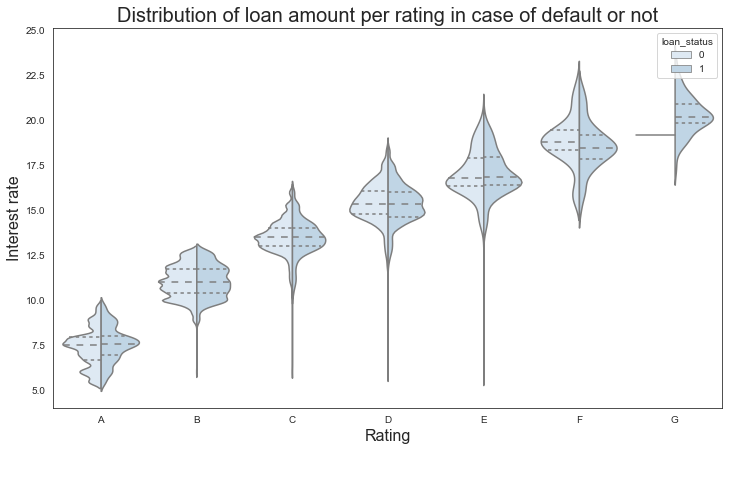

In [25]:
# Define function for plotting
def sns_plot(*plot_args):

    # Settings
    plt.figure(figsize=(12,7))
    plot_dict = plot_args[0]
    df_plot = plot_dict["df"]
    x = plot_dict["x"]
    y = plot_dict["y"]
    plot_options = plot_dict["plot_options"]

    # Differentiate between graphs

    if plot_options["kind"] == "bar":
        g = sns.barplot(x=x, y=y, data=df_plot, palette=plot_options["palette"])
    elif plot_options["kind"] == "count":
        g = sns.countplot(x=x,hue=plot_options["hue"],palette=plot_options["palette"],order=plot_options["order"])
        g.legend(loc="upper left")
    elif plot_options["kind"] == "scatter":
        # g = sns.scatterplot()
        pass
    elif plot_options["kind"] == "violin":
        g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_options["hue"],inner="quart",split=True)
    else:
        raise Exception("Not a valid graph option")

    # Options shared for each graph
    for p in g.patches:
        g.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0,10), textcoords = 'offset points')
    g.set_title(plot_options["title"],fontsize=20)
    g.set_xlabel(plot_options["x_label"],fontsize=16)
    g.set_ylabel(plot_options["y_label"],fontsize=16)
    g.legend(loc="upper left")

    # if plot_dict["kind"] not in ("bar,count,pie"):
    #     print("Not what we would like to have here")
    # elif kind == "bar":
    #     g = sns_

# TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().sort_values(ascending=True).reset_index()

# plot_args = {
#     "df": grade_df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "bar",
#         "title": "Average interest rate per rating",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette":"Blues"
#     }
# }

# plot_args = {
#     "df": df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "violin",
#         "hue": "loan_status",
#         "title": "Distribution of loan amount per rating in case of default or not",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette": {1: "Defaulted", 0: "Not defaulted"}
#     }
# }

# sns_plot(plot_args)  

## TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().plot(kind='bar')
# plot_args = {
#     "kind": "bar",
#     "title": "Average interest rate per rating",
#     "x_label": "Rating",
#     "y_label": "Interest rate"
# }


In [ ]:
#df_cp_loans.

In [ ]:
df_cp_loans.groupby(['loan_grade','loan_status'])['loan_status'].count().plot(kind='bar')

# Here new stuff to merge!

In order to better understand the data we are working with we will carefully analyze each single variable closely to try to understand its meaning and relevance for the problem at hand. If properly handle, this process can ease our analysis and provide with additional information and insights before proceeding into modelling. Preparing a table/dataframe with the following attributes for each of the remaining variable would turn out to be of extremely good use:

* **Variable**: name of the variable
* **Type**: either "categorical" (factor) or numerical (number)
* **Segment**: we could categorize the variable into "n" segments: 

    * Counterparty: variables that give information regarding counterparties 
    * Loans: information on the loan issued to a counterparty
    * Default: either inform on the chance of default a loan has, or whether the counterparty has already defaulted in the past
    
* **Expectation**: our expectation of the influence of this variable on the dependent variable (e.g. either "High","Medium","Low" impact)
* **Conclusion**: our conclusion after taking a look at the data (using same scale as "Expectation" for comparison purposes)
* **Comment**: comment on the result, with a particular focus on describing the difference between expectation and conclusion

This process will help us in setting up what in a statistical setting, and to be more precise, in a Bayesian context a person would call "prior information": we expect that some variables will have a higher impact on the variable that we are trying to model (what we defined "expectation"). The aim of the analysis then is to update such belief and retrieve the "posterior information", or in other words, the updated prior (what we defined "conclusion"). Why is this procedure relevant anyway? To understand this point, consider the following example: [TODO] -> provide an example where not considering prior information might lead you misinterpretation in the conclusion of viceversa


### (3.1) First things first: dig into the dependent variable 

In [57]:
# Retrieve the data
df_ls = df['loan_status'].value_counts().reset_index()

# Mapping to correct values
ls_dict = {
    0: 'Not defaulted (=0)',
    1: 'Defaulted (=1)'
}
df_ls['index'] = df_ls['index'].map(ls_dict)

# Retrieve loan status
df_ls

,index,loan_status
0,Not defaulted (=0),25473
1,Defaulted (=1),7108


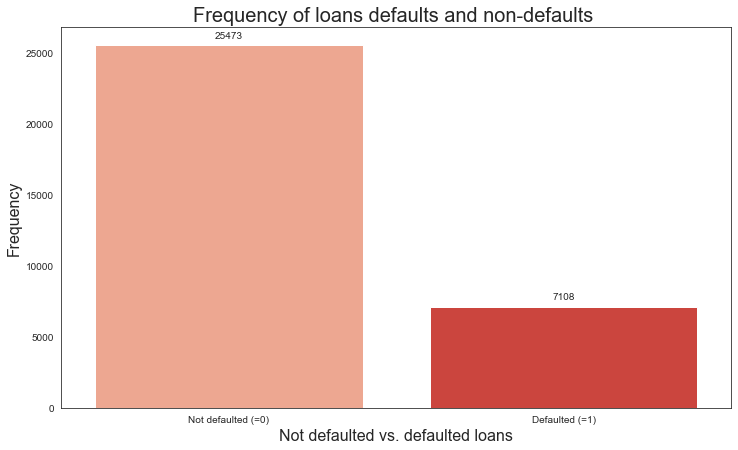

In [59]:
# Plotting distribution
plot_args = {
    "df": df_ls,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "bar",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "Reds"
    }
}

# Get the distribution
sns_plot(plot_args)